In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from skimage import measure, io
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:

# --- Configuration ---
# 1. Path to the *original* CSV file containing metadata and image filenames
#    (The one used as input for the Cellpose script)
metadata_csv_path = '../data/BBBC021_v1_image_smaller.csv' 

# 2. Base directory where the original image folders (e.g., 'Week6/Week6_32061') are located.
#    The paths in your CSV's 'Image_PathName_...' columns should be relative to this.
base_image_dir = Path('../data/') # <<< --- UPDATE THIS if your images aren't relative to the notebook location

# 3. Directory where the '_seg.npy' files were saved.
#    If you saved them next to the original images (output_dir=None in previous script),
#    set this to the same as base_image_dir.
#    If you used a specific output_dir, set it here.
segmentation_dir = Path("./outputs/") # <<< --- UPDATE THIS if you used a specific output_dir for _seg.npy files

# 4. Intensity channel selection (0-based index). Set to None for grayscale.
#    Adjust if your DAPI/Actin images are multi-channel TIFs.
dapi_intensity_channel = None
actin_intensity_channel = None

# 5. Features to extract using regionprops_table
#    'label' and 'centroid' are essential for matching
shape_properties = [
    'label',        # Unique ID for each mask within an image
    'area',
    'perimeter',
    'eccentricity',
    'equivalent_diameter',
    'major_axis_length',
    'minor_axis_length',
    'solidity',
    'orientation',
    'centroid',     # Needed for matching nuclei to cells
]
intensity_properties = [ # Requires intensity_image
    'mean_intensity',
    'max_intensity',
    'min_intensity',
]
# Combine base properties
properties_to_measure = shape_properties + intensity_properties

# --- End Configuration ---

# --- Input Validation ---
if not Path(metadata_csv_path).exists():
    raise FileNotFoundError(f"Metadata CSV file not found: {metadata_csv_path}")

if not base_image_dir.exists():
     raise FileNotFoundError(f"Base image directory not found: {base_image_dir}")

if not segmentation_dir.exists():
     raise FileNotFoundError(f"Segmentation directory not found: {segmentation_dir}")

print("Setup Complete. Paths seem valid.")
print(f"Metadata CSV: {metadata_csv_path}")
print(f"Base Image Dir: {base_image_dir.resolve()}")
print(f"Segmentation Dir: {segmentation_dir.resolve()}")

# Set plot style
sns.set_theme(style="whitegrid")

Setup Complete. Paths seem valid.
Metadata CSV: ../data/BBBC021_v1_image_smaller.csv
Base Image Dir: /home/tomasjelinek/GITHUB/quant_microscopy/data
Segmentation Dir: /home/tomasjelinek/GITHUB/quant_microscopy/processing/outputs


In [3]:
def select_intensity_image(image_stack, channel_index, image_name):
    """Selects the correct channel from an image stack for intensity measurements."""
    if image_stack.ndim > 2: # Multi-channel image
        if channel_index is not None:
            if 0 <= channel_index < image_stack.shape[-1]:
                intensity_img = image_stack[..., channel_index]
                # print(f"Using channel {channel_index} for intensity in {image_name}")
            else:
                print(f"Warning: Channel index {channel_index} out of bounds for {image_name} (shape {image_stack.shape}). Using channel 0.")
                intensity_img = image_stack[..., 0]
        else:
            # Default to first channel if not specified for multi-channel
            intensity_img = image_stack[..., 0]
            # print(f"Warning: Multi-channel image {image_name}, no channel specified. Using channel 0 for intensity.")
    else: # Grayscale image
        intensity_img = image_stack
    return intensity_img

def calculate_additional_features(df, masks, intensity_image):
    """Calculates features not directly available in regionprops_table."""
    # Circularity (Form Factor): 4 * pi * Area / Perimeter^2
    # Add epsilon to prevent division by zero for masks with zero perimeter (e.g., single pixels)
    df['circularity'] = 4 * np.pi * df['area'] / (df['perimeter']**2 + 1e-6)
    df.loc[df['perimeter'] == 0, 'circularity'] = 0 # Define circularity as 0 for single pixels

    # Standard Deviation of Intensity (calculated manually)
    intensity_std_devs = []
    try:
        # Get regionprops objects only once for efficiency
        regions = measure.regionprops(masks, intensity_image=intensity_image)
        # Create a mapping from label to region object
        region_dict = {r.label: r for r in regions}
        # Iterate through the labels in the DataFrame to ensure order matches
        for label in df['label']:
             if label in region_dict:
                 region = region_dict[label]
                 coords = region.coords # shape (N, 2) or (N, 3) for 3D
                 # Ensure correct indexing for potentially 3D coords/images
                 if intensity_image.ndim == 3 and coords.shape[1] == 3:
                     region_intensities = intensity_image[coords[:, 0], coords[:, 1], coords[:, 2]]
                 elif intensity_image.ndim == 2 and coords.shape[1] == 2:
                     region_intensities = intensity_image[coords[:, 0], coords[:, 1]]
                 else:
                      # Fallback or error if dimensions mismatch unexpectedly
                      print(f"Warning: Dimension mismatch between coords ({coords.shape}) and intensity image ({intensity_image.ndim}) for label {label}. Skipping std dev.")
                      intensity_std_devs.append(np.nan)
                      continue

                 intensity_std_devs.append(np.std(region_intensities))
             else:
                 # This case shouldn't happen if df is derived correctly from regionprops
                 intensity_std_devs.append(np.nan)


        if len(intensity_std_devs) == len(df):
            df['intensity_std_dev'] = intensity_std_devs
        else:
             print(f"Warning: Mismatch calculating std dev. Lengths: {len(intensity_std_devs)} vs {len(df)}")


    except Exception as e:
         print(f"Warning: Could not calculate intensity std dev: {e}")
         df['intensity_std_dev'] = np.nan # Add column with NaNs if calculation fails

    return df


def extract_features(mask_image, intensity_image, properties, prefix):
    """Extracts features using regionprops_table and adds a prefix."""
    if np.max(mask_image) == 0: # No masks found
        return pd.DataFrame() # Return empty DataFrame

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning) # Ignore warnings like perimeter on edge
            props_table = measure.regionprops_table(
                label_image=mask_image,
                intensity_image=intensity_image,
                properties=properties
            )
        features_df = pd.DataFrame(props_table)

        # Calculate and add additional features
        features_df = calculate_additional_features(features_df, mask_image, intensity_image)

        # Add prefix to all columns except 'label' (which is used for merging)
        features_df = features_df.rename(columns={
            col: f"{prefix}_{col}" for col in features_df.columns if col != 'label'
        })
        return features_df

    except Exception as e:
        print(f"Error during feature extraction for prefix {prefix}: {e}")
        # Return an empty DataFrame or handle error as appropriate
        return pd.DataFrame()


def match_nuclei_to_cells(nuclei_df, cell_masks):
    """Matches nuclei to cells based on nucleus centroid location."""
    if nuclei_df.empty or 'nuc_centroid-0' not in nuclei_df.columns:
        print("Warning: Nuclei DataFrame is empty or missing centroid columns. Cannot match.")
        return pd.DataFrame() # Return empty if no nuclei or centroids

    matched_cell_labels = []
    max_y, max_x = cell_masks.shape[:2] # Get image dimensions from cell masks

    for idx, nucleus in nuclei_df.iterrows():
        # Get nucleus centroid coordinates (y, x)
        centroid_y = int(round(nucleus['nuc_centroid-0']))
        centroid_x = int(round(nucleus['nuc_centroid-1']))

        # Ensure centroid coordinates are within image bounds
        if 0 <= centroid_y < max_y and 0 <= centroid_x < max_x:
            # Find the label of the cell mask at the nucleus centroid location
            cell_label = cell_masks[centroid_y, centroid_x]
            matched_cell_labels.append(cell_label)
        else:
            # Centroid is outside image bounds (shouldn't usually happen with regionprops)
            # print(f"Warning: Nucleus {nucleus['label']} centroid ({centroid_y}, {centroid_x}) out of bounds ({max_y}, {max_x}).")
            matched_cell_labels.append(0) # Assign background label (0)

    # Add the matched cell label to the nuclei DataFrame
    nuclei_df['matched_cell_label'] = matched_cell_labels

    # Filter out nuclei whose centroids didn't fall into any cell mask (label 0)
    matched_nuclei = nuclei_df[nuclei_df['matched_cell_label'] > 0].copy()

    return matched_nuclei


def process_image_pair(dapi_seg_path, actin_seg_path, dapi_img_path, actin_img_path):
    """Loads data for an image pair, extracts features, matches, and combines."""

    # --- Load Data ---
    try:
        dapi_seg_data = np.load(dapi_seg_path, allow_pickle=True).item()
        dapi_masks = dapi_seg_data['masks']
        dapi_img = io.imread(dapi_img_path)

        actin_seg_data = np.load(actin_seg_path, allow_pickle=True).item()
        actin_masks = actin_seg_data['masks']
        actin_img = io.imread(actin_img_path)
    except FileNotFoundError as e:
        print(f"Error loading file: {e}. Skipping this pair.")
        return None
    except Exception as e:
        print(f"Error processing pair ({dapi_img_path.name}, {actin_img_path.name}): {e}")
        return None

    # --- Prepare Intensity Images ---
    dapi_intensity = select_intensity_image(dapi_img, dapi_intensity_channel, dapi_img_path.name)
    actin_intensity = select_intensity_image(actin_img, actin_intensity_channel, actin_img_path.name)

    # --- Validate Shapes ---
    if dapi_masks.shape != dapi_intensity.shape or actin_masks.shape != actin_intensity.shape:
        print(f"Warning: Shape mismatch for {dapi_img_path.name} or {actin_img_path.name}. Skipping.")
        print(f"  DAPI Mask: {dapi_masks.shape}, DAPI Intensity: {dapi_intensity.shape}")
        print(f"  Actin Mask: {actin_masks.shape}, Actin Intensity: {actin_intensity.shape}")
        return None

    # --- Extract Features ---
    nuclei_features = extract_features(dapi_masks, dapi_intensity, properties_to_measure, "nuc")
    cell_features = extract_features(actin_masks, actin_intensity, properties_to_measure, "cell")

    if nuclei_features.empty:
        print(f"No nuclei features extracted for {dapi_img_path.name}. Skipping match.")
        return None
    if cell_features.empty:
        print(f"No cell features extracted for {actin_img_path.name}. Skipping match.")
        # Still return nuclei features maybe? Or skip entirely? Let's skip for now.
        return None


    # --- Match Nuclei to Cells ---
    # Rename nucleus label column before matching to avoid conflict after merge
    nuclei_features = nuclei_features.rename(columns={'label':'nucleus_label'})
    matched_nuclei_df = match_nuclei_to_cells(nuclei_features, actin_masks)

    if matched_nuclei_df.empty:
        print(f"No nuclei were successfully matched to cells for {dapi_img_path.name}. Skipping.")
        return None

    # --- Merge Features ---
    # Rename cell label column to match the 'matched_cell_label' in matched_nuclei_df
    cell_features = cell_features.rename(columns={'label':'cell_label'})

    # Perform the merge based on the matched cell label
    # Use left merge to keep all matched nuclei, even if cell feature extraction failed for some reason
    # (though we check for empty cell_features earlier)
    combined_df = pd.merge(
        matched_nuclei_df,
        cell_features,
        left_on='matched_cell_label',
        right_on='cell_label',
        how='left'
    )

    # Optionally, drop redundant columns like matched_cell_label and cell_label if desired
    # combined_df = combined_df.drop(columns=['matched_cell_label', 'cell_label'])

    return combined_df


print("Helper functions defined.")

Helper functions defined.


In [10]:
# --- Main Loop ---
if not os.path.exists(metadata_csv_path):

    all_features_list = []
    processed_files_count = 0
    error_count = 0

    print(f"Reading metadata from: {metadata_csv_path}")
    metadata_df = pd.read_csv(metadata_csv_path)
    print(f"Found {len(metadata_df)} rows in metadata CSV.")

    for index, row in tqdm(metadata_df.iterrows()):
        try:
            # Use Path objects for robustness
            # DAPI Paths
            dapi_rel_path = Path(row['Image_PathName_DAPI'])
            dapi_filename = Path(row['Image_FileName_DAPI'])
            dapi_img_path = base_image_dir / dapi_rel_path / dapi_filename
            dapi_seg_filename = Path(f"{dapi_filename.stem}_seg.npy") # Assumes standard naming
            dapi_seg_path = segmentation_dir / dapi_seg_filename # Look for seg file relative to segmentation_dir

            # Actin Paths
            actin_rel_path = Path(row['Image_PathName_Actin'])
            actin_filename = Path(row['Image_FileName_Actin'])
            actin_img_path = base_image_dir / actin_rel_path / actin_filename
            actin_seg_filename = Path(f"{actin_filename.stem}_seg.npy") # Assumes standard naming
            actin_seg_path = segmentation_dir / actin_seg_filename # Look for seg file relative to segmentation_dir

            # --- Check File Existence ---
            files_ok = True
            for p in [dapi_img_path, dapi_seg_path, actin_img_path, actin_seg_path]:
                if not p.exists():
                    print(f"  Missing file: {p}. Skipping this row.")
                    files_ok = False
                    error_count += 1
                    break # Stop checking files for this row

            if not files_ok:
                continue # Move to the next row

            # --- Process Pair ---
            features_single_pair = process_image_pair(
                dapi_seg_path, actin_seg_path, dapi_img_path, actin_img_path
            )

            # --- Add Metadata and Append ---
            if features_single_pair is not None and not features_single_pair.empty:
                # Add metadata from the current CSV row
                for col in metadata_df.columns:
                    # Avoid adding path/filename columns if not desired, or add selectively
                    if "FileName" not in col and "PathName" not in col:
                        features_single_pair[col] = row[col]
                # Add source filenames for reference
                features_single_pair['source_dapi_image'] = dapi_filename.name
                features_single_pair['source_actin_image'] = actin_filename.name

                all_features_list.append(features_single_pair)
                processed_files_count += 1
                # print(f"  Successfully processed pair. Found {len(features_single_pair)} matched cells.")
            else:
                # print(f"  No features generated or matched for this pair.")
                error_count += 1


        except KeyError as e:
            print(f"  Error: Missing expected column in CSV: {e}. Skipping row {index+1}.")
            error_count += 1
        except Exception as e:
            print(f"  Unexpected error processing row {index+1}: {e}")
            error_count += 1


    # --- Concatenate Results ---
    print(f"\nConcatenating features from {processed_files_count} processed image pairs...")
    combined_features_df = pd.concat(all_features_list, ignore_index=True)
    combined_features_df.to_csv("combined_features.csv", index=False)
    print("Concatenation complete.")

    print(f"\n--- Processing Summary ---")
    print(f"Total rows in CSV: {len(metadata_df)}")
    print(f"Image pairs processed successfully: {processed_files_count}")
    print(f"Rows skipped due to errors or missing files: {error_count}")
    if not combined_features_df.empty:
        print(f"Total matched nucleus-cell objects found: {len(combined_features_df)}")

In [5]:
combined_features_df = pd.read_csv("combined_features.csv")

In [6]:
combined_features_df["Image_Metadata_Compound"].unique()

array(['acyclovir', 'AG-1478', 'calpain inhibitor 2 (ALLM)',
       'Cdk1 inhibitor III', 'Cdk1/2 inhibitor (NU6102)',
       'chloramphenicol', 'cytochalasin D', 'epothilone B', 'leupeptin',
       'LY-294002', 'neomycin', 'puromycin', 'rapamycin', 'staurosporine',
       'trichostatin', 'tunicamycin', 'Y-27632', 'AZ-B', 'AZ-I', 'AZ-J',
       'AZ-M', 'AZ-N'], dtype=object)

In [27]:
#treatment1 = 'Cdk1/2 inhibitor (NU6102)'
#treatment2 = 'epothilone B'

treatment1 = "cytochalasin D"
treatment2 = "epothilone B"

In [28]:
# values of concentrations for each compound
combined_features_df[combined_features_df["Image_Metadata_Compound"] == treatment1]["Image_Metadata_Concentration"].unique()


array([3.e-03, 1.e-02, 3.e-02, 1.e-01, 1.e+00, 3.e+00, 1.e+01, 3.e-01])

In [29]:

combined_features_df[combined_features_df["Image_Metadata_Compound"] == treatment2]["Image_Metadata_Concentration"].unique()

array([1.e-03, 3.e-03, 1.e-02, 3.e-02, 3.e+00, 1.e-01, 3.e-01, 1.e+00])


Generating distribution plots...


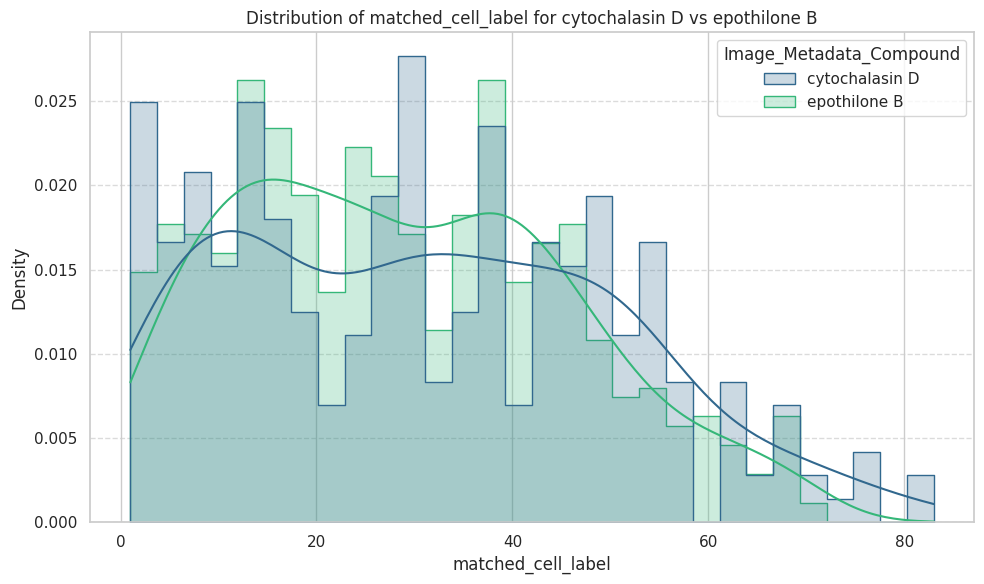

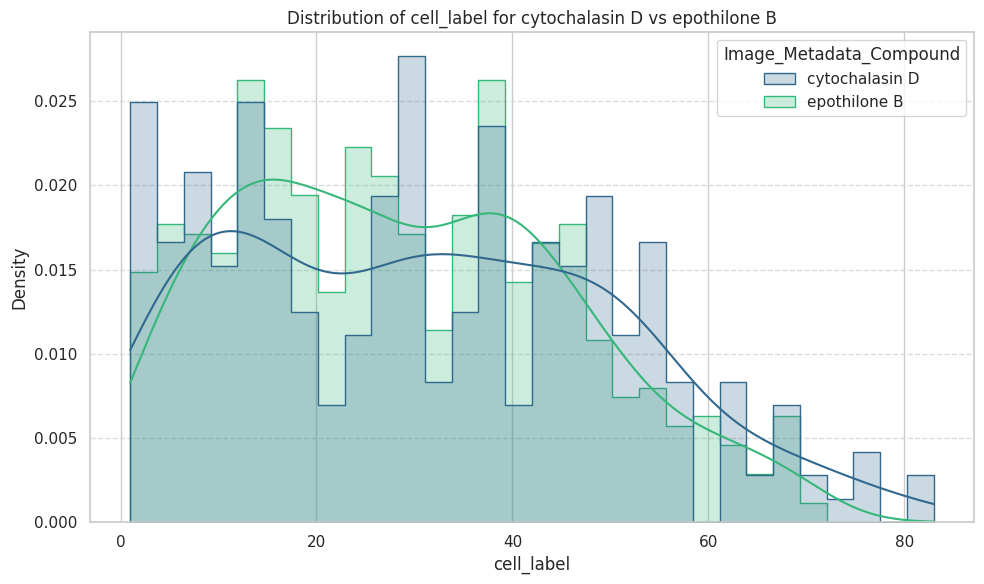

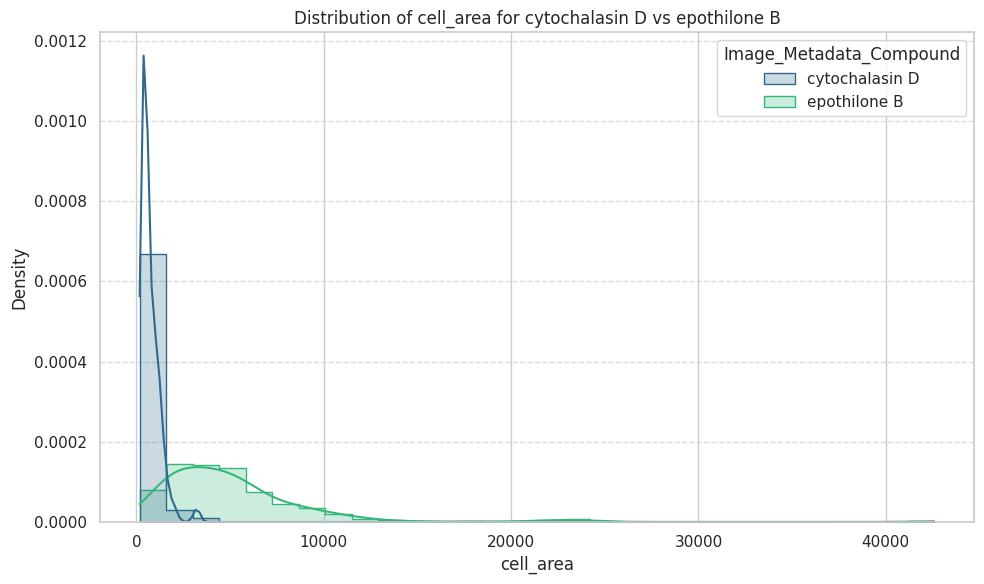

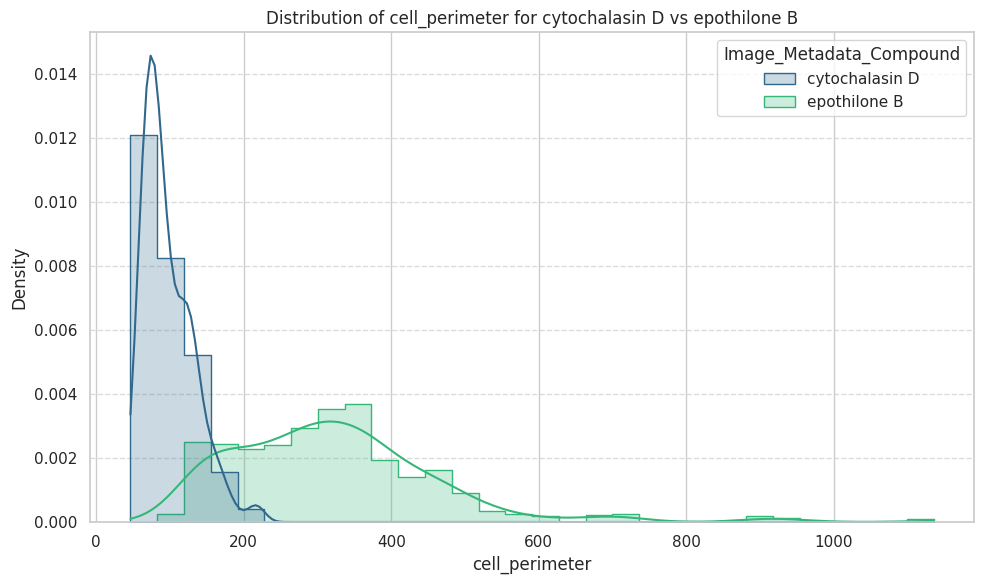

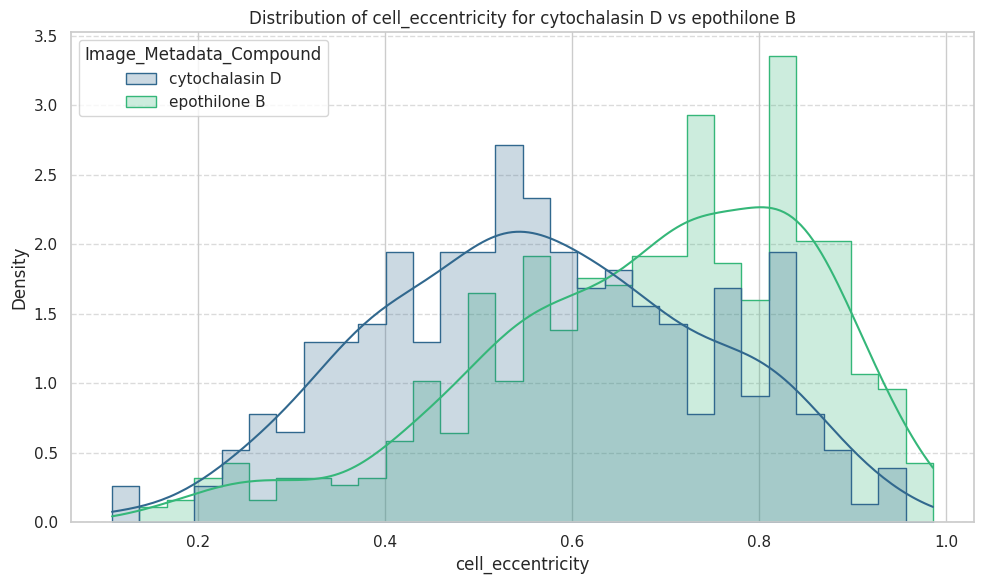

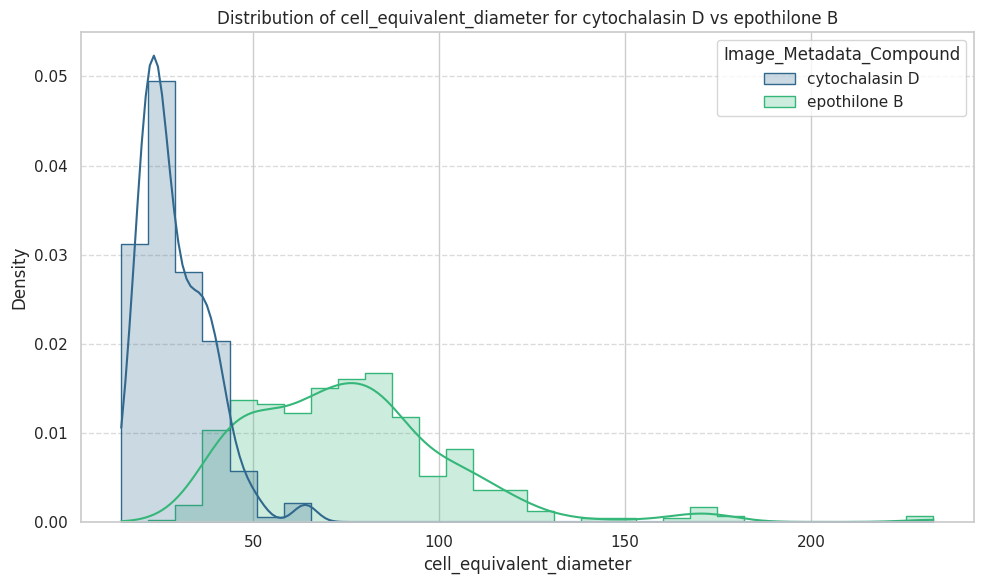

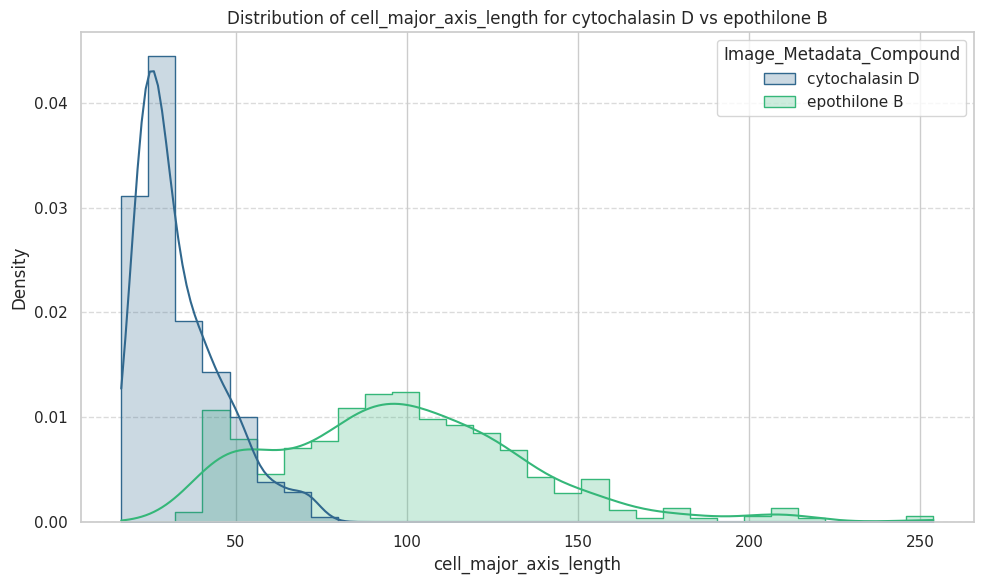

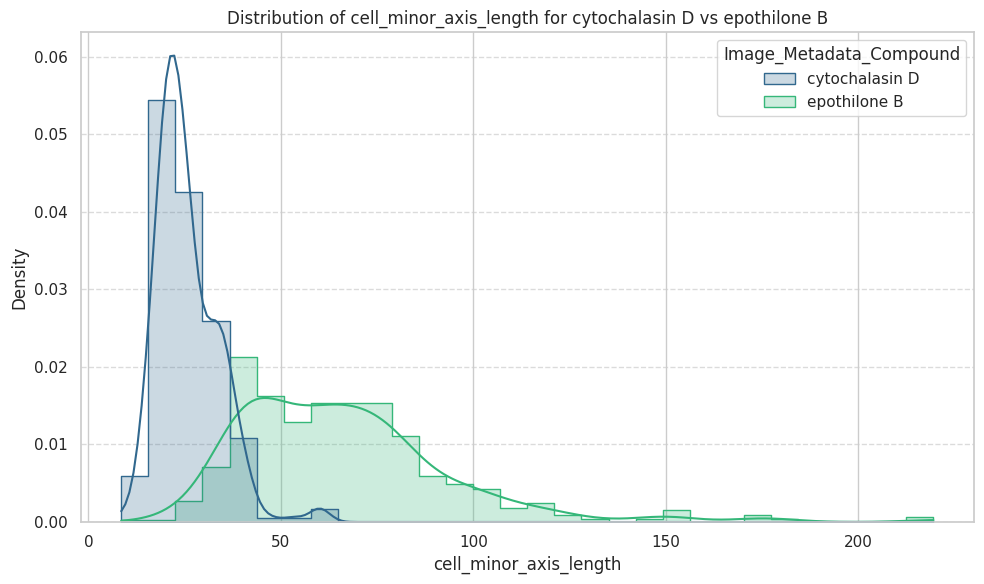

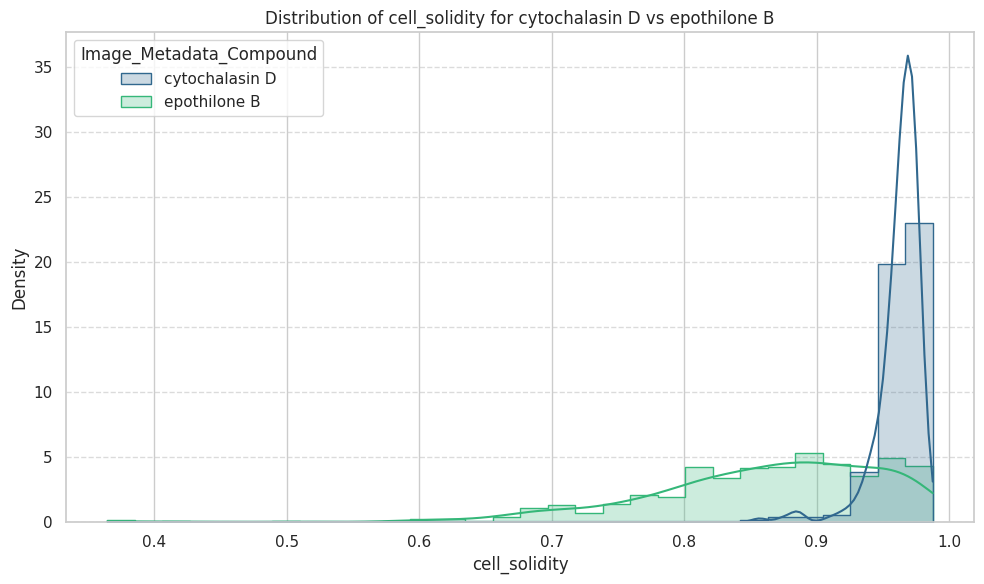

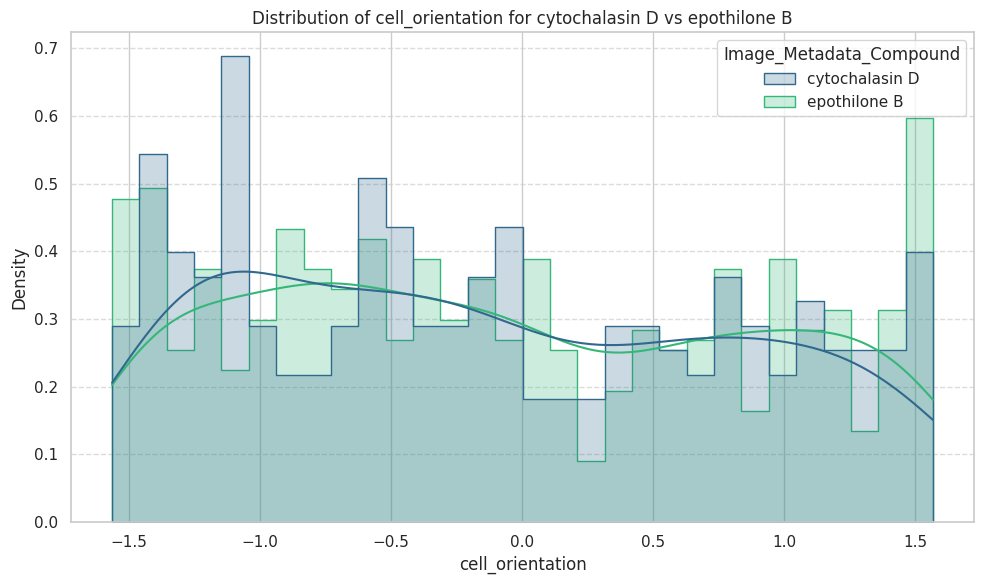

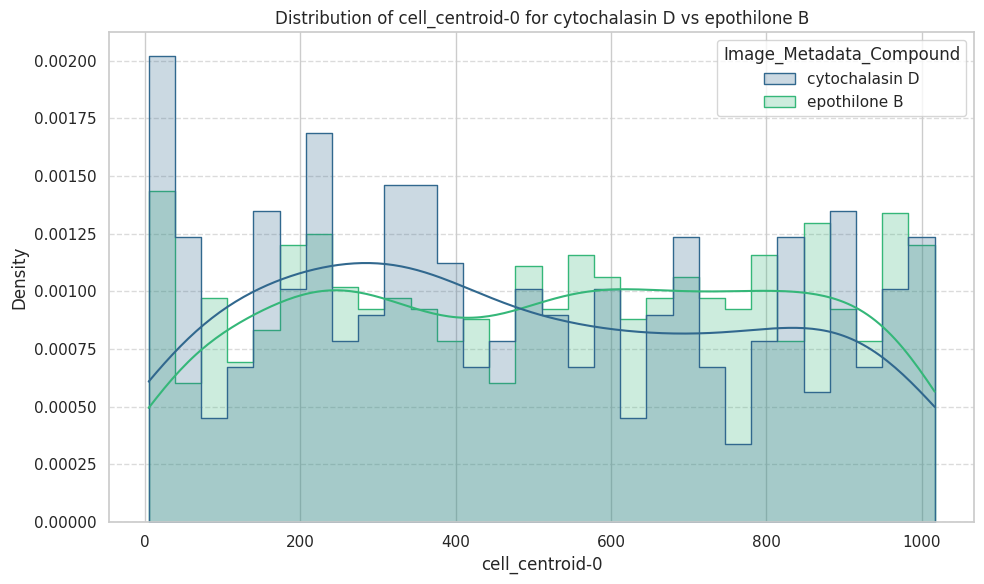

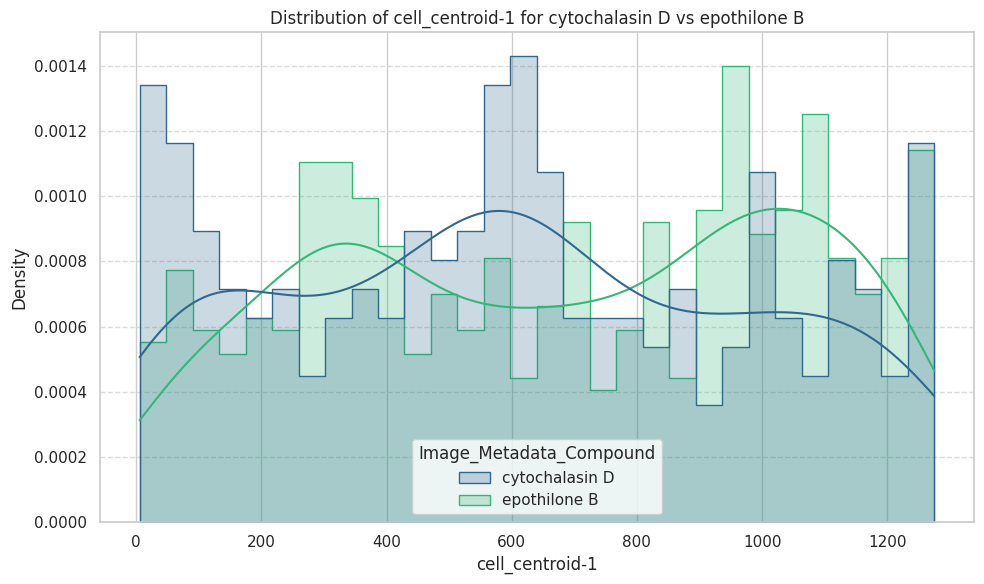

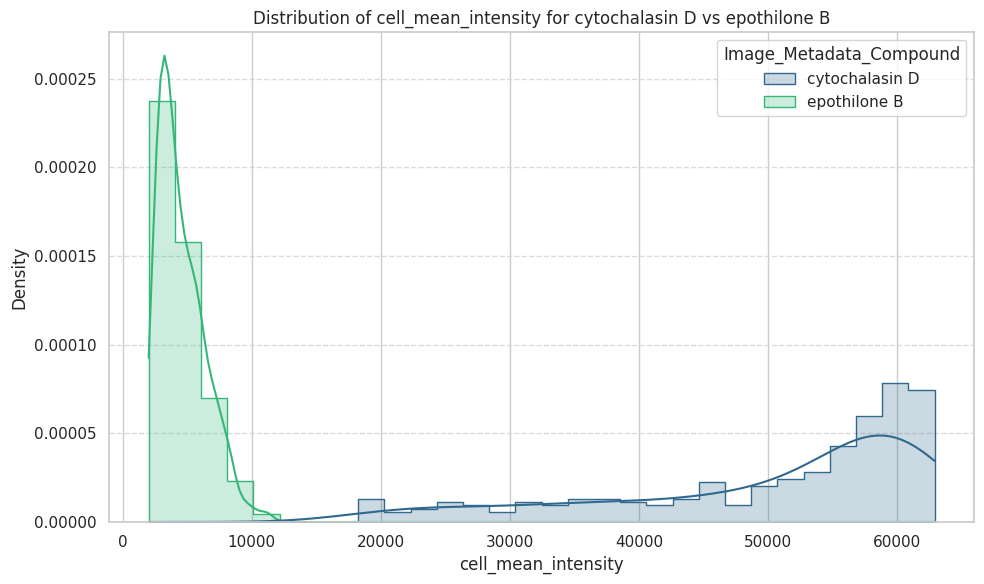

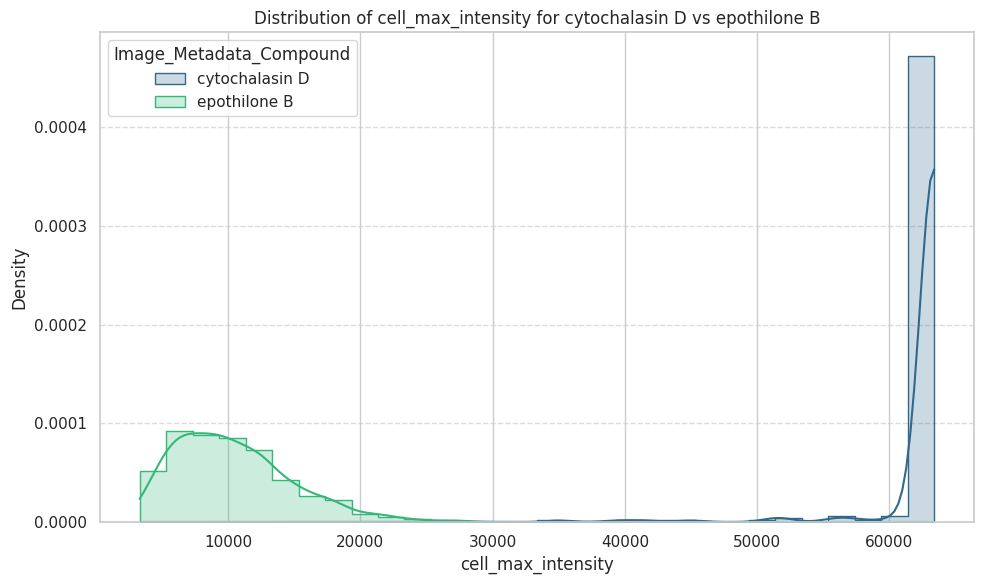

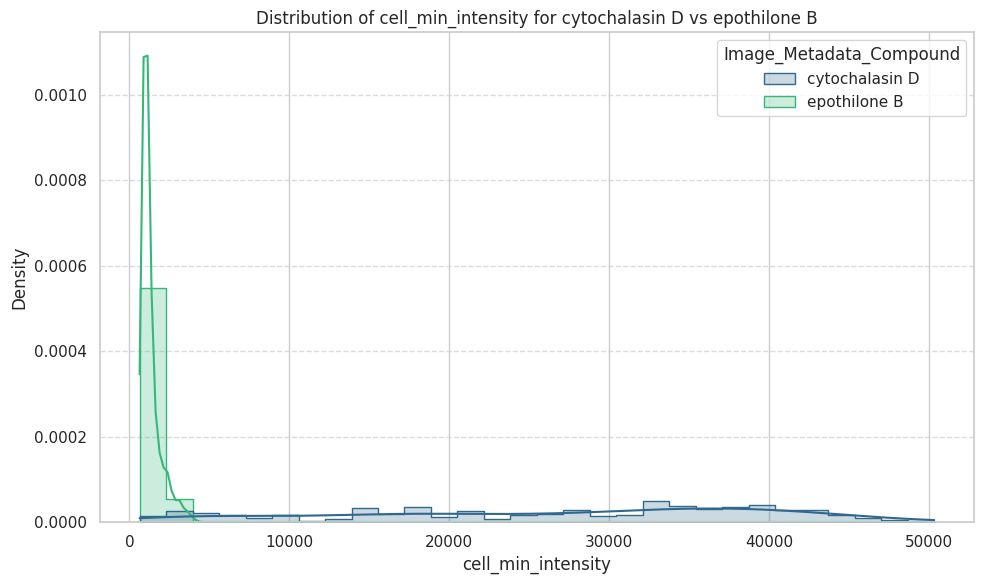

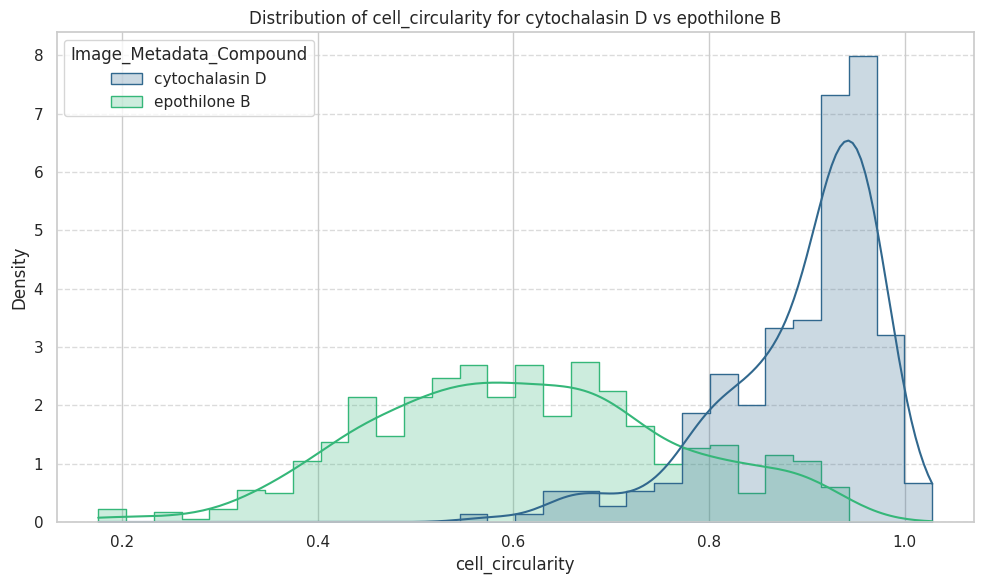

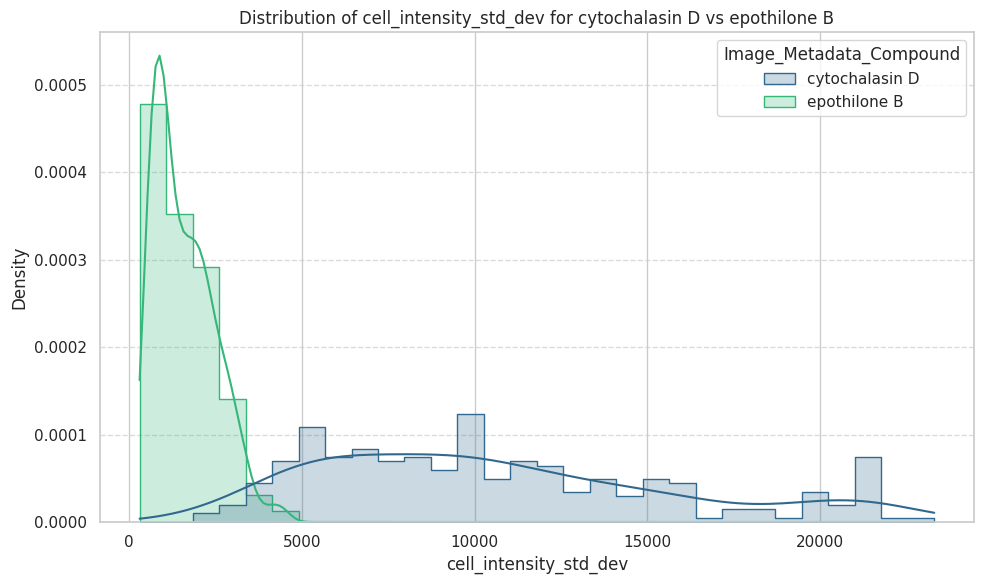

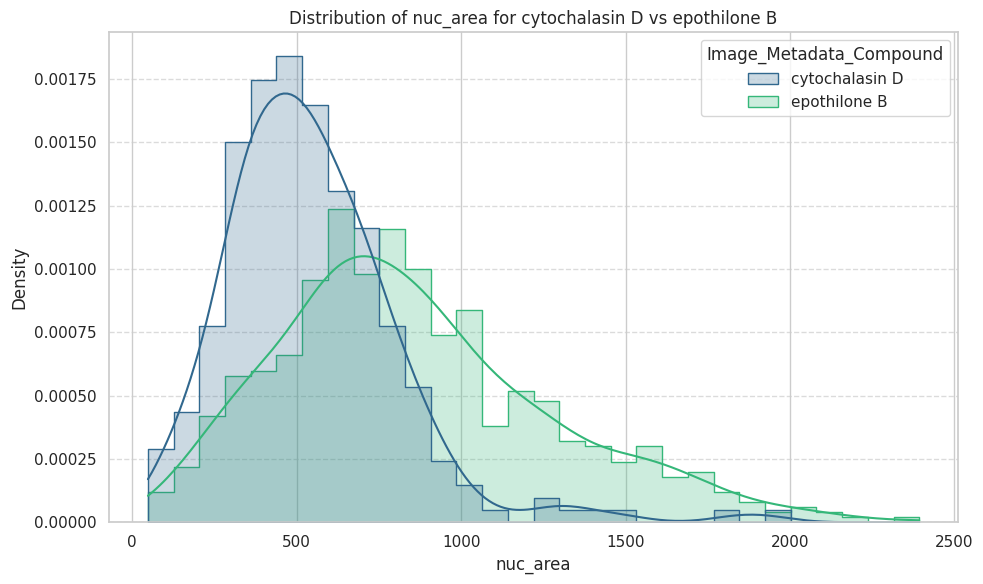

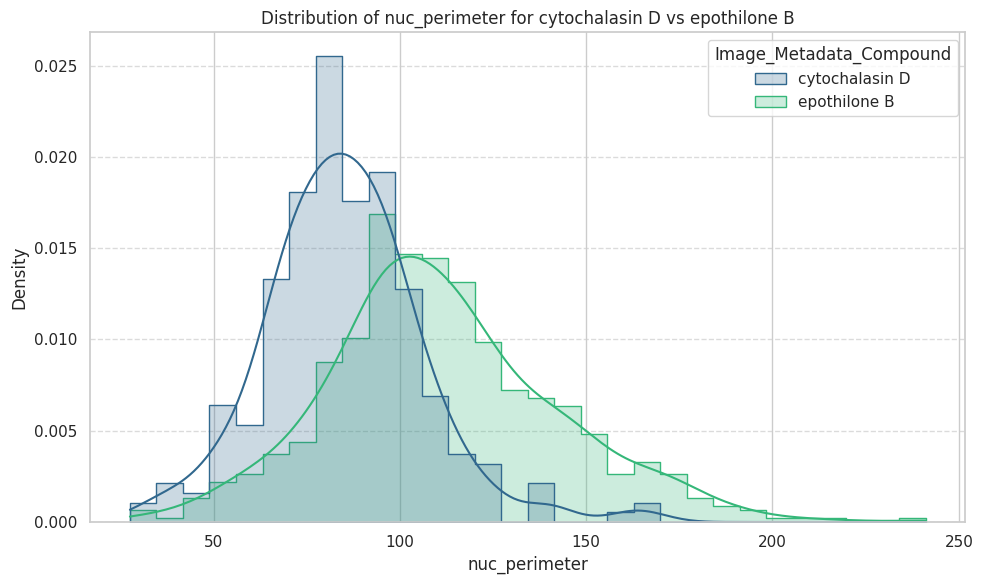

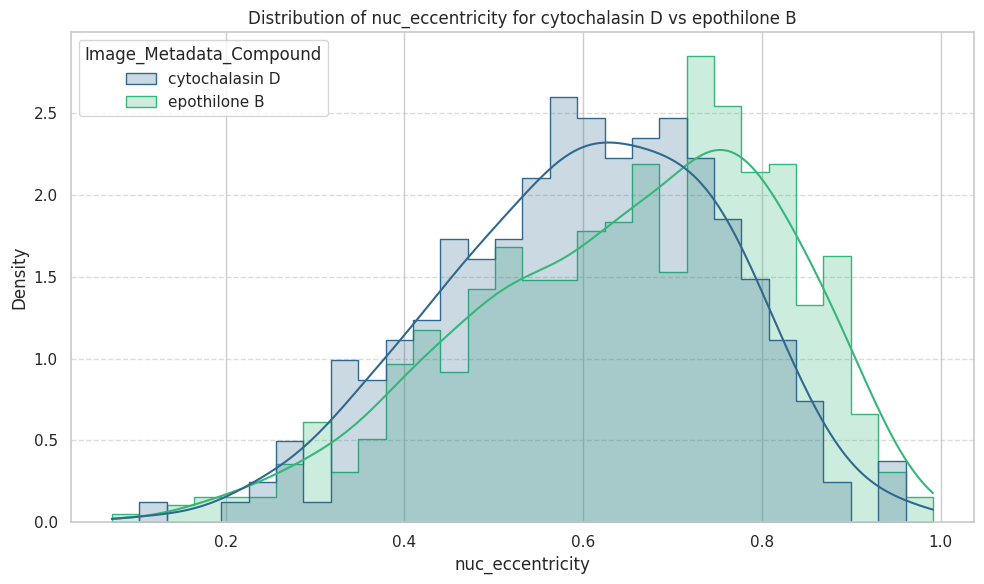

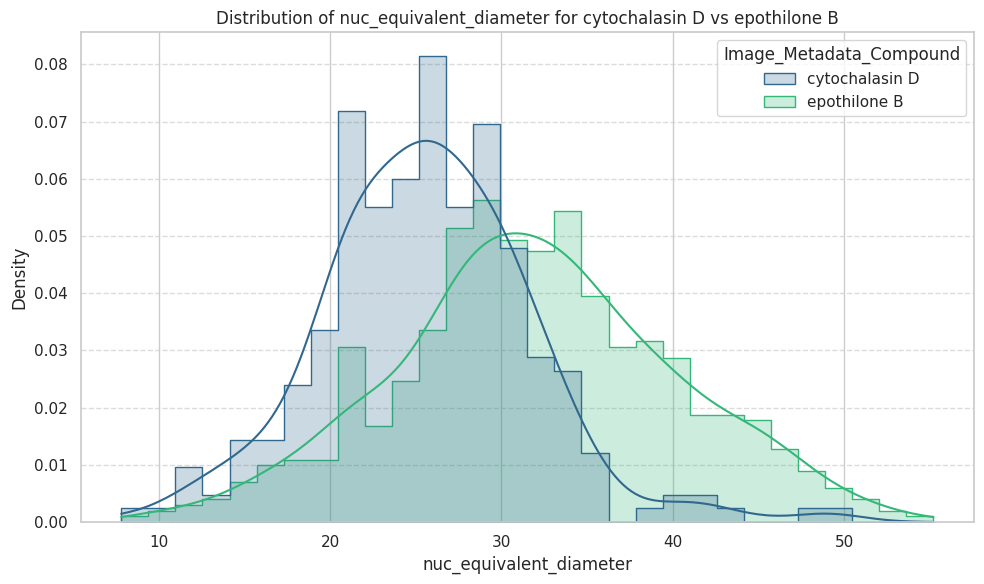

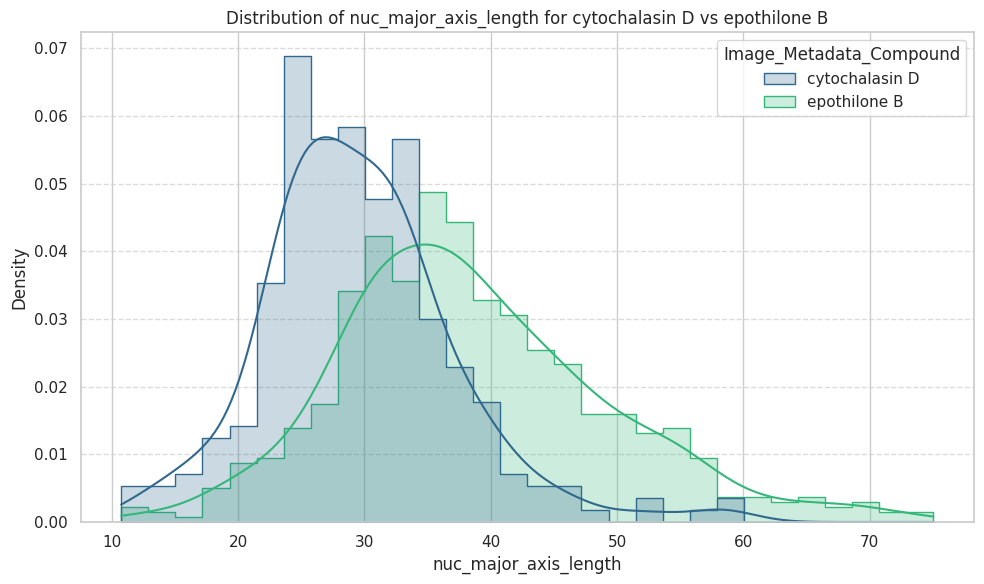

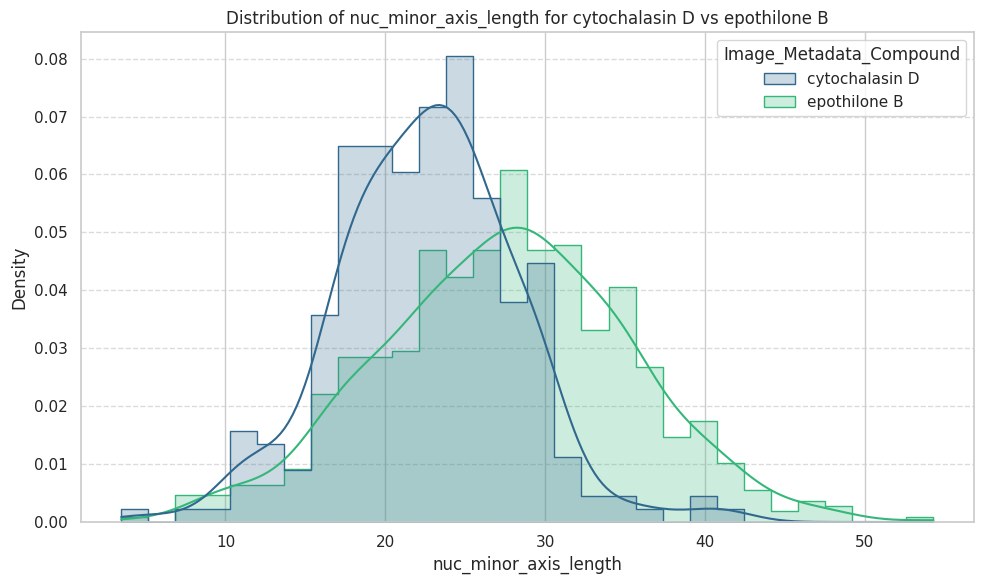

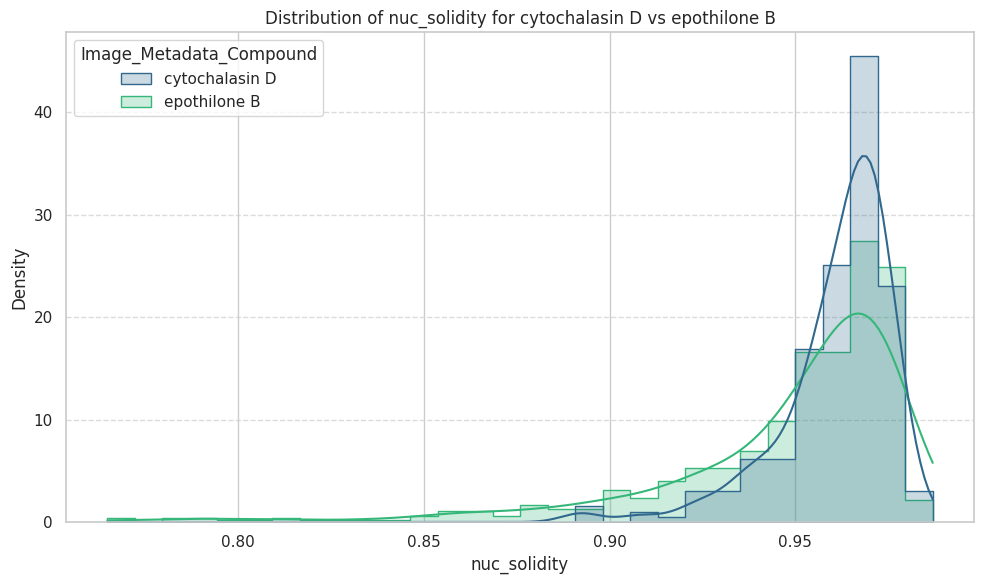

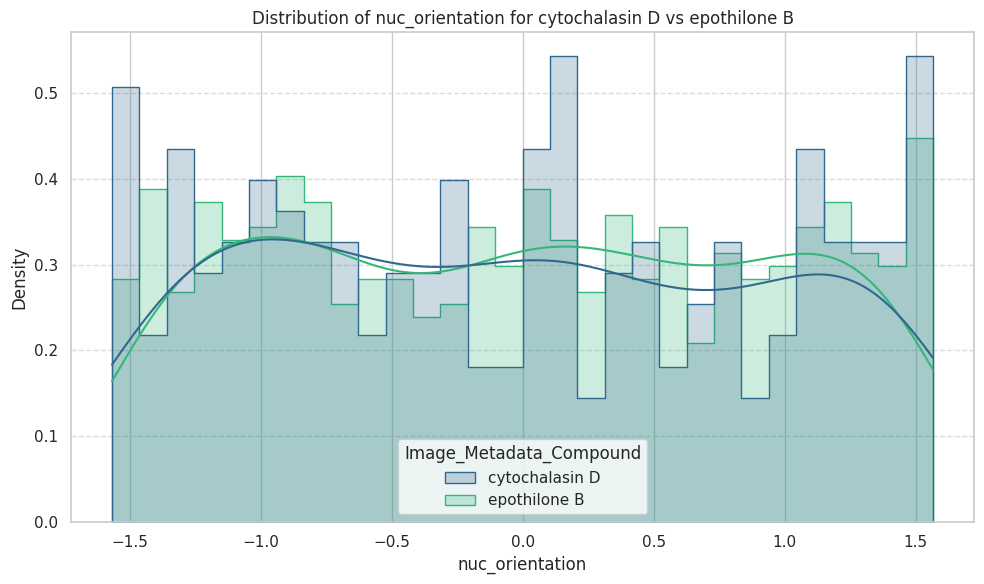

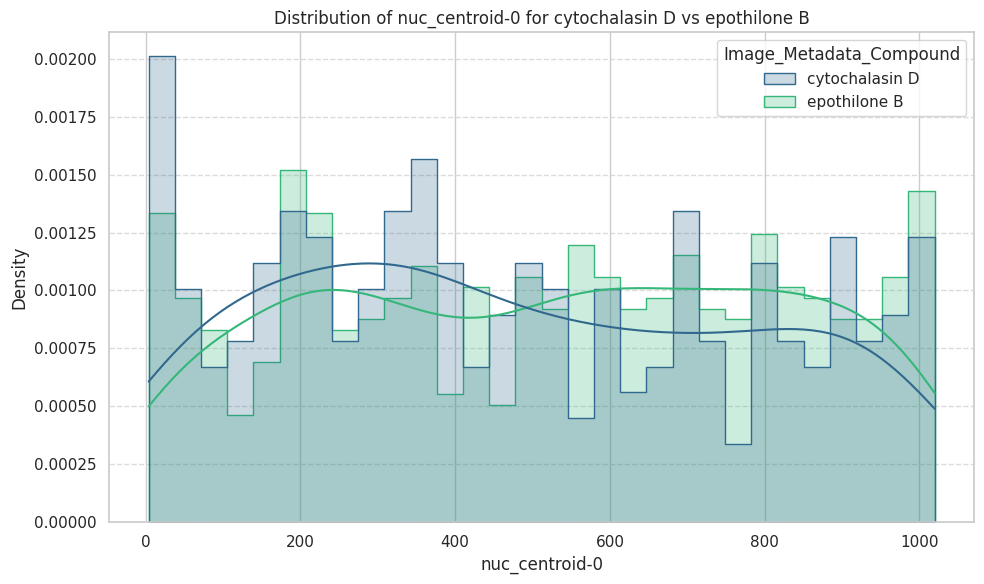

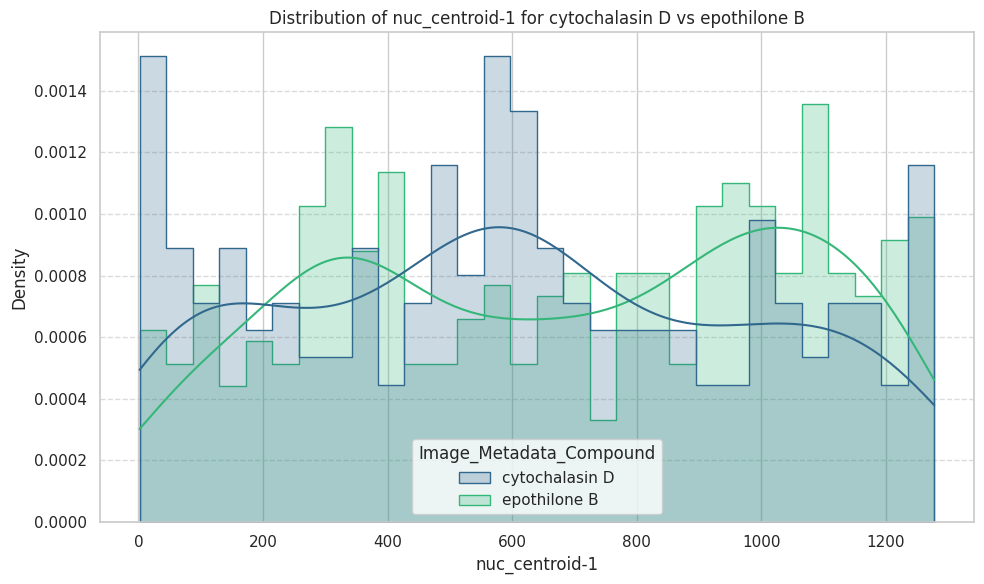

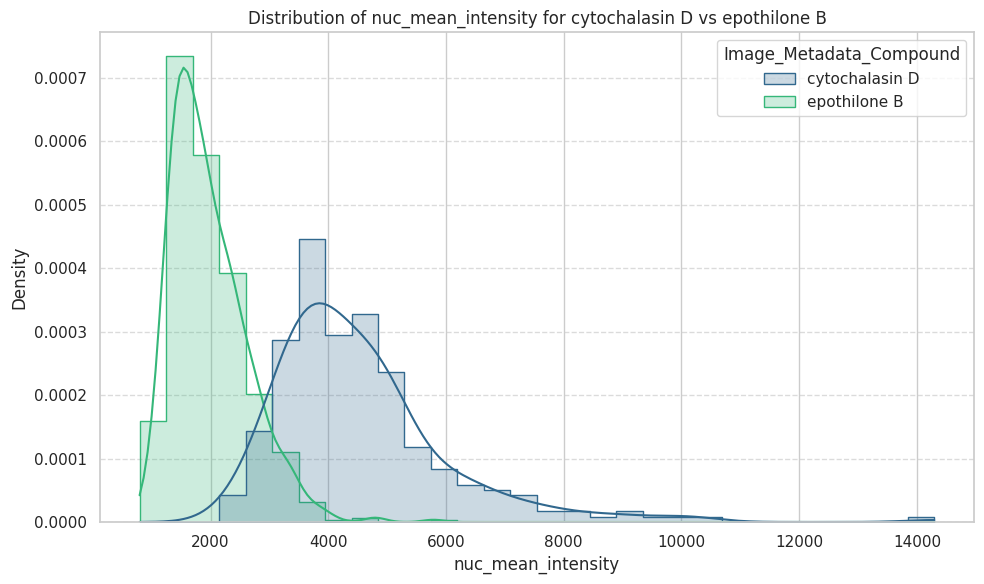

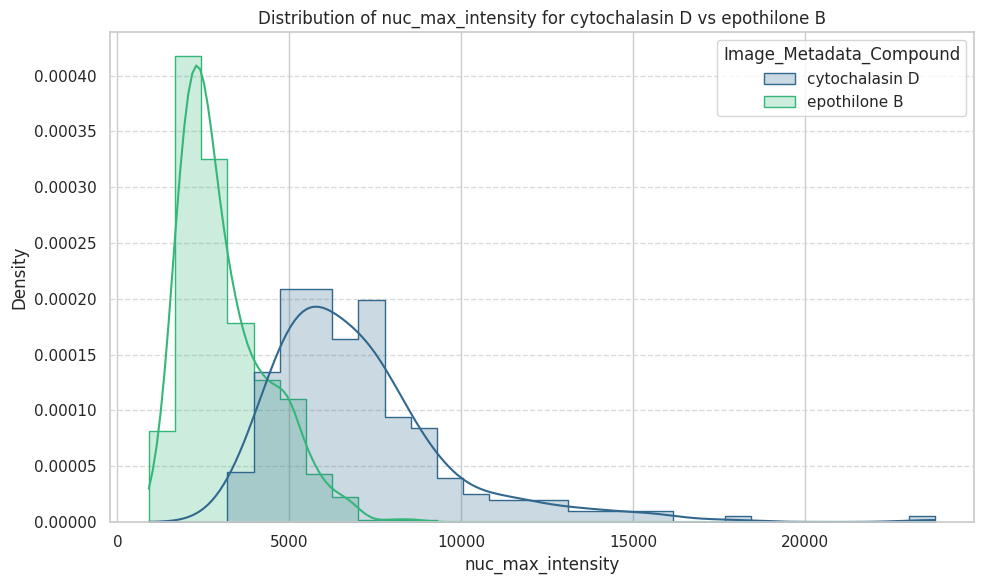

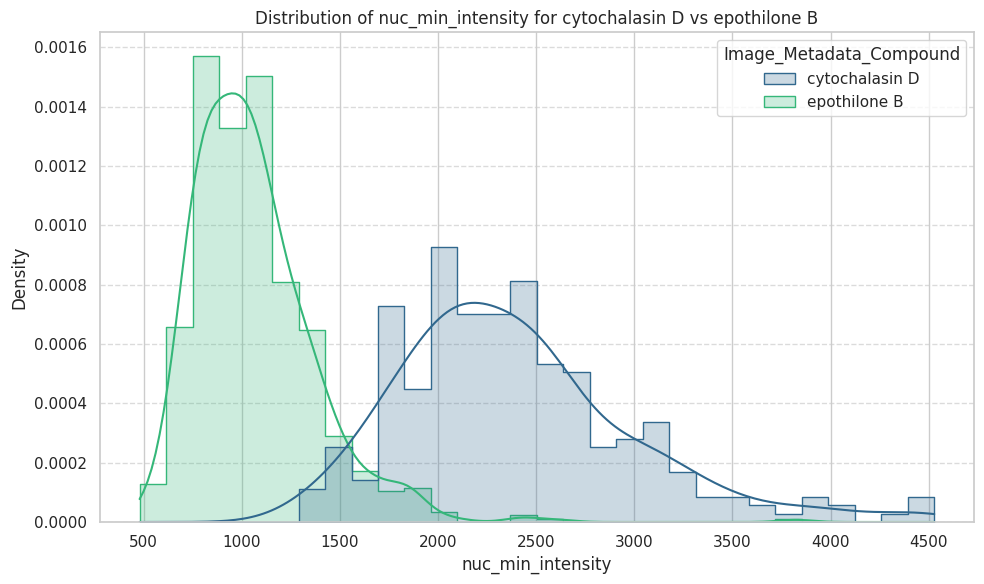

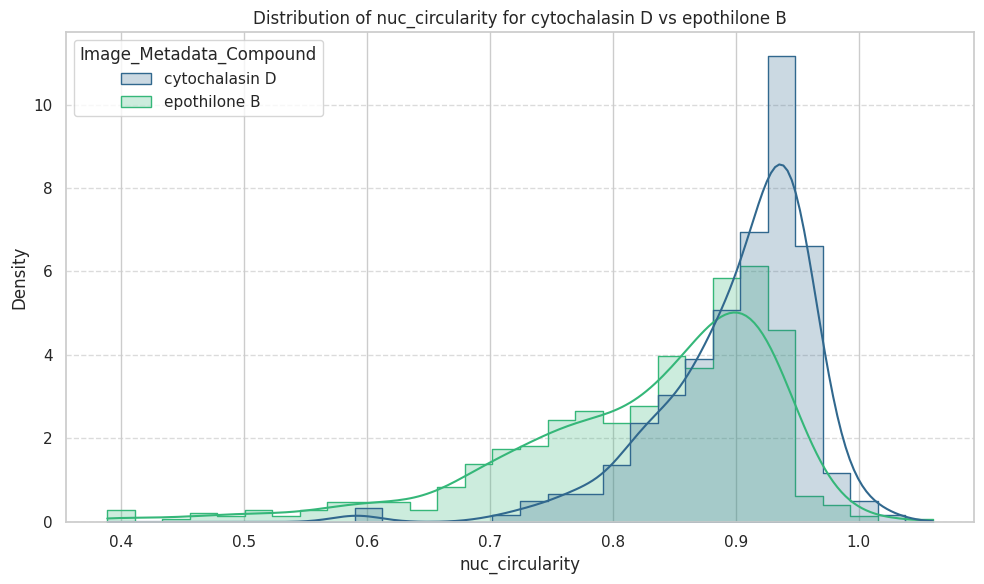

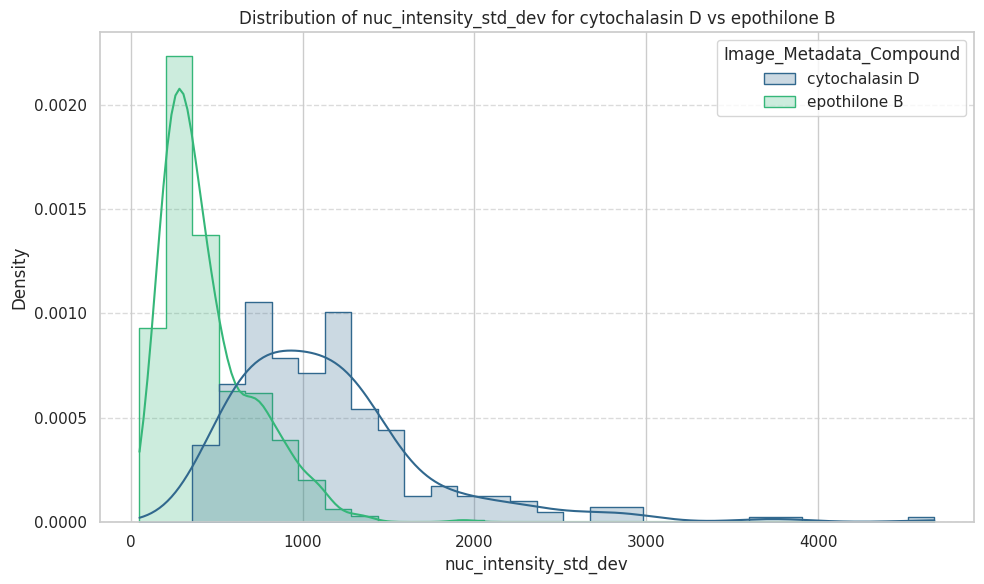


Analysis complete. Plots displayed.


In [45]:
features_to_compare = [
    'cell_area',
    'cell_eccentricity',
    'cell_mean_intensity',
    'cell_circularity'
]

features_to_compare = combined_features_df.columns[combined_features_df.columns.str.contains('cell_')].tolist() + combined_features_df.columns[combined_features_df.columns.str.contains('nuc_')].tolist()


concentration1 = 10.0
concentration2 = 1.0

# --- Load Data ---
features_file = "combined_features.csv"
df_features = pd.read_csv(features_file)

# --- Identify Available Treatments ---
available_compounds = df_features['Image_Metadata_Compound'].unique()

# --- Filter Data for Selected Treatments ---
df_filtered = df_features[df_features['Image_Metadata_Compound'].isin([treatment1, treatment2])].copy() # Use copy to avoid SettingWithCopyWarning

# Filter by concentration if needed
if concentration1:
    df_filtered = df_filtered[
        (df_filtered['Image_Metadata_Compound'] == treatment1) & 
        (df_filtered['Image_Metadata_Concentration'] == concentration1) |
        (df_filtered['Image_Metadata_Compound'] == treatment2) & 
        (df_filtered['Image_Metadata_Concentration'] == concentration2)
    ]



print("\nGenerating distribution plots...")
if df_filtered.empty:
    print("Filtered DataFrame is empty. Cannot generate plots.")
else:
    for feature in features_to_compare:
        if feature not in df_filtered.columns:
            print(f"Warning: Feature '{feature}' not found in the dataframe. Skipping.")
            continue

        plt.figure(figsize=(10, 6))

        # Using seaborn's histplot or kdeplot for distribution comparison
        sns.histplot(data=df_filtered, x=feature, hue='Image_Metadata_Compound',
                        kde=True, # Add Kernel Density Estimate curve
                        bins=30,  # Adjust number of bins as needed
                        palette='viridis', # Choose a color palette
                        element='step', # Use steps for histogram bars for clearer comparison
                        stat='density', # Normalize histograms
                        common_norm=False # Normalize each histogram independently
                    )

        plt.title(f'Distribution of {feature} for {treatment1} vs {treatment2}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f'plots/{treatment1}vs{treatment2}_distribution_{feature}.pdf')
        plt.show()

    print("\nAnalysis complete. Plots displayed.")


Analyzing treatment: 'cytochalasin D'
Found concentrations (sorted): [np.float64(0.003), np.float64(0.01), np.float64(0.03), np.float64(0.1), np.float64(0.3), np.float64(1.0), np.float64(3.0), np.float64(10.0)]

Generating separate distribution plots for each feature...


FileNotFoundError: [Errno 2] No such file or directory: 'plots/cytochalasin D/matched_cell_label_distribution.pdf'

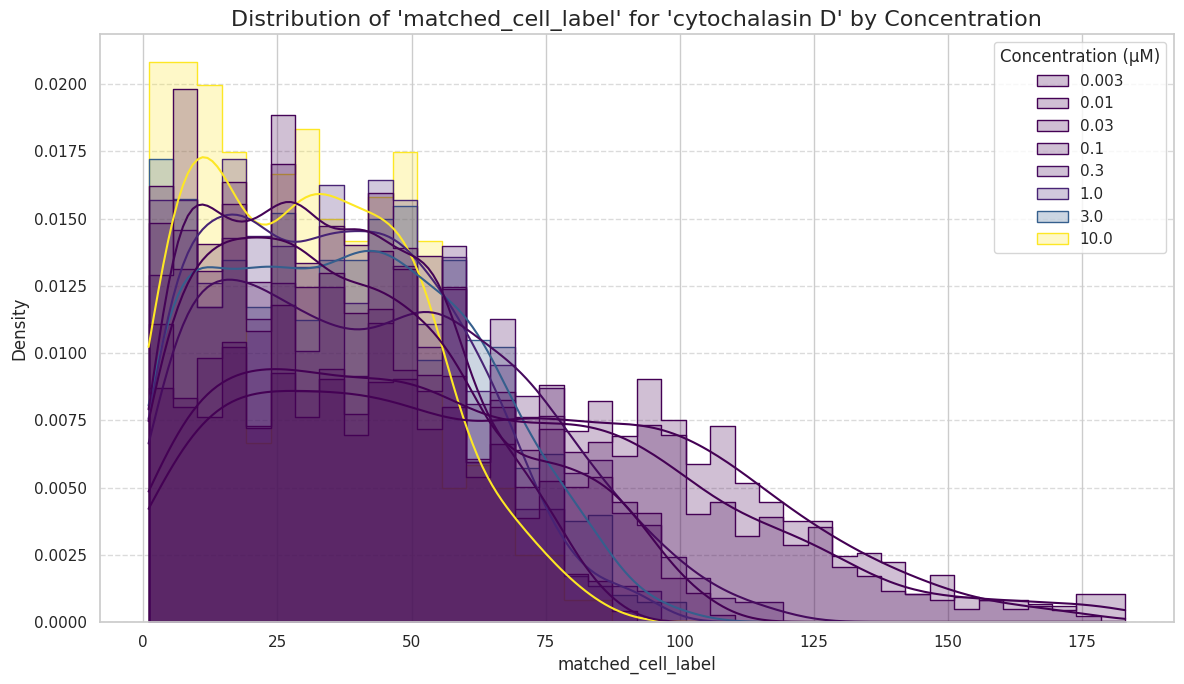

In [ ]:
import numpy as np # Make sure numpy is imported for ceil

# --- Configuration for Concentration-based Analysis ---
selected_treatment = 'cytochalasin D' # <<< --- UPDATE THIS to your compound of interest

# Set to True to generate one figure with all plots, or False for separate plots.
generate_single_plot = False # <<< --- SET THIS to True or False

features_to_compare = combined_features_df.columns[combined_features_df.columns.str.contains('cell_')].tolist() + \
                      combined_features_df.columns[combined_features_df.columns.str.contains('nuc_')].tolist()

df_single_treatment = combined_features_df[combined_features_df['Image_Metadata_Compound'] == selected_treatment].copy()
available_concentrations = sorted(df_single_treatment['Image_Metadata_Concentration'].unique())

print(f"Analyzing treatment: '{selected_treatment}'")
print(f"Found concentrations (sorted): {available_concentrations}")

if df_single_treatment.empty:
    print("\nNo data found for the selected treatment. Cannot generate plots.")

elif generate_single_plot:
    print("\nGenerating a single figure with all feature distributions...")
    num_features = len(features_to_compare)
    num_cols = 4 
    num_rows = int(np.ceil(num_features / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten() 
    for i, feature in enumerate(features_to_compare):
        ax = axes[i]
        sns.histplot(data=df_single_treatment,
                     x=feature,
                     hue='Image_Metadata_Concentration',
                     hue_order=available_concentrations, 
                     kde=True,
                     bins=40,
                     palette='viridis',
                     element='step',
                     stat='density',
                     common_norm=False,
                     ax=ax, 
                     legend=(i == 0) 
                    )
        ax.set_title(f"Distribution of '{feature}'")
        ax.set_xlabel(None) 
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    if num_features > 0:
        legend = fig.axes[0].get_legend()
        if legend:
            legend.set_title('Concentration (µM)')
            sns.move_legend(fig.axes[0], "upper left", bbox_to_anchor=(1, 1))

    for j in range(num_features, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Feature Distributions for '{selected_treatment}'", fontsize=20, y=1.02)
    plt.tight_layout(rect=[0, 0, 0.9, 1]) 
    plt.savefig(f"plots/{selected_treatment}_feature_distributions.pdf", dpi=600) 
    plt.show()

else:
    print("\nGenerating separate distribution plots for each feature...")
    for feature in features_to_compare:
        plt.figure(figsize=(12, 7))
        ax = sns.histplot(data=df_single_treatment,
                          x=feature,
                          hue='Image_Metadata_Concentration',
                          hue_order=available_concentrations, # Use the sorted order
                          kde=True,
                          bins=40,
                          palette='viridis',
                          element='step',
                          stat='density',
                          common_norm=False)

        legend = ax.get_legend()
        if legend: 
            legend.set_title('Concentration (µM)')

        plt.title(f"Distribution of '{feature}' for '{selected_treatment}' by Concentration", fontsize=16)
        plt.xlabel(feature, fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        if not os.path.exists("plots"):
            os.makedirs("plots")
        plt.savefig(f"plots/{selected_treatment}/{feature}_distribution.pdf", dpi=600) # Save each plot
        plt.show()

print("\nAnalysis complete.")